# Elastic wave equation implementation on a staggered grid

This is a first attempt at implemenenting the elastic wave equation as described in:

[1] Jean Virieux (1986). ”P-SV wave propagation in heterogeneous media: Velocity‐stress finite‐difference method.” GEOPHYSICS, 51(4), 889-901. https://doi.org/10.1190/1.1442147

The current version actually attempts to mirror the FDELMODC implementation by Jan Thorbecke:

[2] https://janth.home.xs4all.nl/Software/fdelmodcManual.pdf

## Explosive source

We will first attempt to replicate the explosive source test case described in [1], Figure 4. We start by defining the source signature $g(t)$, the derivative of a Gaussian pulse, given by Eq 4:

$$g(t) = -2 \alpha(t - t_0)e^{-\alpha(t-t_0)^2}$$

In [1]:
from devito import *
from examples.seismic.source import WaveletSource, RickerSource, GaborSource
from examples.seismic import plot_image
import numpy as np

from sympy import init_printing, latex
init_printing(use_latex=True)

In [2]:
# Initial grid: 1km x 1km, with spacing 100m
extent = (2000., 2000.)
shape = (201, 201)
x = SpaceDimension(name='x', spacing=Constant(name='h_x', value=extent[0]/(shape[0]-1)))
z = SpaceDimension(name='z', spacing=Constant(name='h_z', value=extent[1]/(shape[1]-1)))
grid = Grid(extent=extent, shape=shape, dimensions=(x, z))

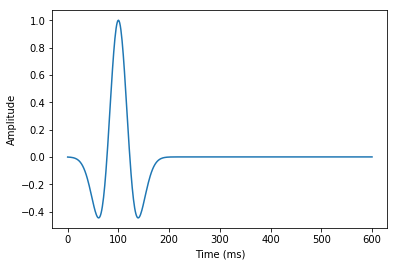

In [3]:
class DGaussSource(WaveletSource):
    
    def wavelet(self, f0, t):
        a = 0.004
        return -2.*a*(t - 1/f0) * np.exp(-a * (t - 1/f0)**2)

# Timestep size from Eq. 7 with V_p=6000. and dx=100
t0, tn = 0., 600.
dt = (10. / np.sqrt(2.)) / 6.
nt = int(1 + (tn-t0) / dt)  # Discrete time axis length
time = np.linspace(t0, tn, nt)  # Discrete modelling time

src = RickerSource(name='src', grid=grid, f0=0.01, time=time)
src.coordinates.data[:] = [1000., 1000.]
src.show()

In [4]:
# Now we create the velocity and pressure fields
vx= TimeFunction(name='vx', grid=grid, staggered=(0, 1, 0))
vz = TimeFunction(name='vz', grid=grid, staggered=(0, 0, 1))
txx = TimeFunction(name='txx', grid=grid)
tzz = TimeFunction(name='tzz', grid=grid)
txz = TimeFunction(name='txz', grid=grid, staggered=(0, 1, 1))

# And finally we create the discretized/indexed symbols
VX = vx.indexed
VZ = vz.indexed
TXX = txx.indexed
TZZ = tzz.indexed
TXZ = txz.indexed

In [5]:
def derivative(f, dim, order, stagger=centered):
    """
    Utility function to generate staggered derivatives
    """
    diff = dim.spacing
    if stagger == left:
        off = -.5
    elif stagger == right:
        off = .5
    else:
        off = 0.
    idx = [(dim + int(i+.5+off)*diff) for i in range(-int(order / 2), int(order / 2))]
    return f.diff(dim).as_finite_difference(idx, x0=dim + off*dim.spacing)

In [6]:
# Now let's try and create the staggered updates
t = grid.stepping_dim
time = grid.time_dim

# We need some initial conditions
V_p = 4.0
V_s = 1.0
density = 3.

# The source injection term
src_xx = src.inject(field=txx, expr=src)
src_zz = src.inject(field=tzz, expr=src)

#c1 = 9.0/8.0;
#c2 = -1.0/24.0;

# Thorbecke's parameter notation
cp2 = V_p*V_p
cs2 = V_s*V_s
ro = 1/density

mu = cs2*ro
l = (cp2*ro - 2*mu)

# fdelmodc reference implementation
u_vx = Eq(vx.forward, vx - dt*ro*(derivative(txx, dim=x, order=4, stagger=left)
                                + derivative(txz, dim=z, order=4, stagger=right)))

u_vz = Eq(vz.forward, vz - ro*dt*(derivative(txz, dim=x, order=4, stagger=right)
                                + derivative(tzz, dim=z, order=4, stagger=left)))

u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * derivative(vx.forward, dim=x, order=4, stagger=right)
                            -  l*dt       * derivative(vz.forward, dim=z, order=4, stagger=right))
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * derivative(vz.forward, dim=z, order=4, stagger=right)
                            -  l*dt       * derivative(vx.forward, dim=x, order=4, stagger=right))

u_txz = Eq(txz.forward, txz - mu*dt * (derivative(vx.forward, dim=z, order=4, stagger=left)
                                     + derivative(vz.forward, dim=x, order=4, stagger=left)))

In [7]:
op = Operator(src_xx + src_zz + [u_vx, u_vz, u_txx, u_tzz, u_txz], dse=None, dle=None)


In [8]:
# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op(time=nt-1)

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-hl8m7q3d/170412f256a4ede5ed83afaa96ddb61cbf77b7b0.c [0.63 s]
Section section_0<510,1> with OI=3.44 computed in 0.000 s [0.48 GFlops/s]
Section main<510,197,197> with OI=3.00 computed in 6.434 s [0.37 GFlops/s, 0.00 GPts/s]


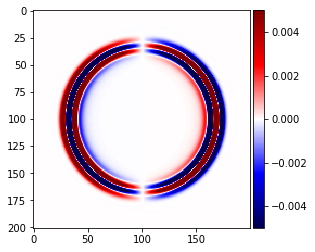

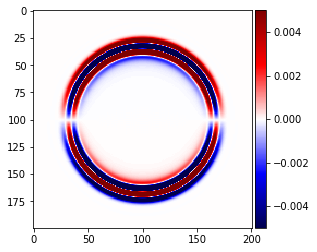

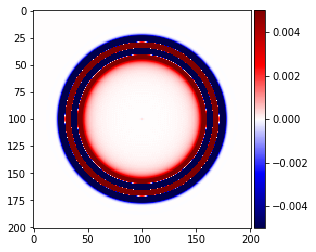

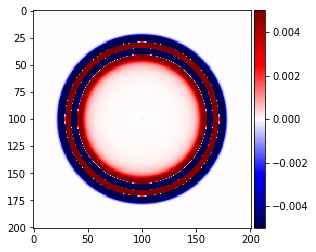

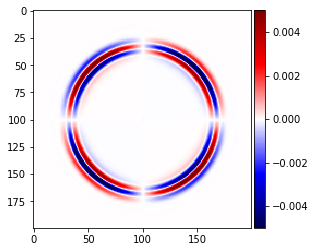

In [9]:
# Let's see what we got....
plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")

CustomCompiler: compiled /var/folders/qr/4hc1nw7d3hj55jbd1z7kkrvh0000gn/T/devito-hl8m7q3d/26fddb94fe8546a9b7dbb3317d889590d4cd7c07.c [0.51 s]
Section section_0<510,1> with OI=3.44 computed in 0.000 s [0.50 GFlops/s]
Section main<510,189,189> with OI=9.00 computed in 21.476 s [0.31 GFlops/s, 0.00 GPts/s]


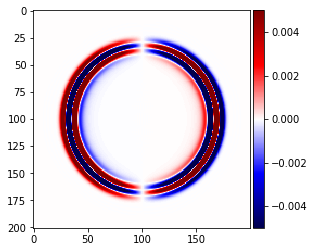

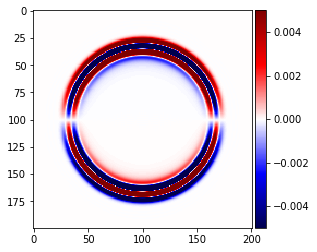

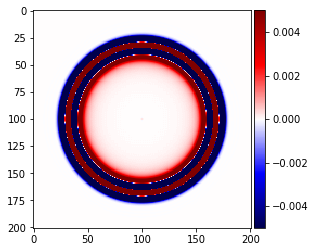

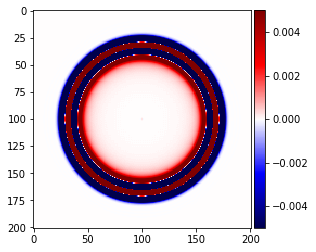

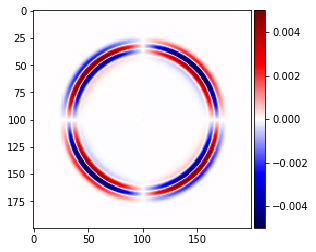

In [10]:
# Now that looks pretty! But let's do it again with a higher order...
order = 12

u_vx = Eq(vx.forward, vx - dt*ro*(derivative(txx, dim=x, order=order, stagger=left)
                                + derivative(txz, dim=z, order=order, stagger=right)))
u_vz = Eq(vz.forward, vz - ro*dt*(derivative(txz, dim=x, order=order, stagger=right)
                                + derivative(tzz, dim=z, order=order, stagger=left))) 
u_txx = Eq(txx.forward, txx - (l+2*mu)*dt * derivative(vx.forward, dim=x, order=order, stagger=right)
                            -  l*dt       * derivative(vz.forward, dim=z, order=order, stagger=right))
u_tzz = Eq(tzz.forward, tzz - (l+2*mu)*dt * derivative(vz.forward, dim=z, order=order, stagger=right)
                            -  l*dt       * derivative(vx.forward, dim=x, order=order, stagger=right))
u_txz = Eq(txz.forward, txz - mu*dt * (derivative(vx.forward, dim=z, order=order, stagger=left)
                                     + derivative(vz.forward, dim=x, order=order, stagger=left)))

op = Operator(src_xx + src_zz + [u_vx, u_vz, u_txx, u_tzz, u_txz], dse=None, dle=None)

# Reset the fields
vx.data[:] = 0.
vz.data[:] = 0.
txx.data[:] = 0.
tzz.data[:] = 0.
txz.data[:] = 0.

op(time=nt-1)

plot_image(vx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(vz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txx.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(tzz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")
plot_image(txz.data[0], vmin=-.5*1e-2, vmax=.5*1e-2, cmap="seismic")